In [1]:
from zoish.feature_selectors.gridshap import GridSearchCVShapFeatureSelector
import xgboost
import logging
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
grid_classification_xgb = GridSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=xgboost.XGBClassifier(),
        estimator_params={
        "max_depth": [4, 5],
        "min_child_weight": [0.1, 0.9],
        "gamma": [1, 9],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        performance_metric = 'f1',
        cv = StratifiedKFold(n_splits=3, shuffle=True),

)


root - INFO - Setting value for logging_basicConfig
root - INFO - Getting value for logging_basicConfig
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_d

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', grid_classification_xgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for estimator_params
root - INFO - Getting value for performance metric
root - INFO - Getting value for verbose
root - INFO - Getting value for grid_search_n_jobs
root - INFO - Getting value for cv
root - INFO - Getting value for xgbse_focus


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.707 total time=   0.4s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.716 total time=   0.5s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.706 total time=   0.4s
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.705 total time=   0.4s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.708 total time=   0.4s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.706 total time=   0.4s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.702 total time=   0.5s
[CV 2/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.718 total time=   0.5s
[CV 3/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.701 total time=   0.5s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.9;, score=0.707 total time=   0.5s
[CV 2/3] END gamma=1, max_depth=5, min_child_weigh

root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


XGBClassifier


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for n_features


.values =
array([[-1.76851738e+00,  4.17613696e-02,  9.68875147e-02, ...,
        -4.75534339e-02, -1.85964726e-01,  2.09022304e-03],
       [-6.56236035e-01,  2.87446645e-02,  1.06629661e-01, ...,
        -3.50758678e-02, -1.35062387e-01, -1.25922513e-03],
       [ 2.44369757e-01,  4.21279775e-02, -3.36316951e-01, ...,
        -4.07980874e-02, -1.02634546e-01,  6.86008410e-03],
       ...,
       [ 5.79821422e-01,  4.19104343e-02, -3.65535869e-01, ...,
        -5.84636094e-02,  4.23126645e-01,  6.95370474e-03],
       [-1.00233748e+00,  6.32604401e-02, -5.45138454e-01, ...,
        -6.38543808e-02,  4.51763265e-01,  1.80740118e-02],
       [-1.95589224e+00,  3.45844228e-02,  2.44787431e-01, ...,
        -4.11663289e-02, -2.25867765e-01,  1.66150921e-02]])

.base_values =
array([[-1.40767555],
       [-1.40767555],
       [-1.40767555],
       ...,
       [-1.40767555],
       [-1.40767555],
       [-1.40767555]])

.data =
array([[    24,      1, 228649, ...,      0,     38,      1],
 

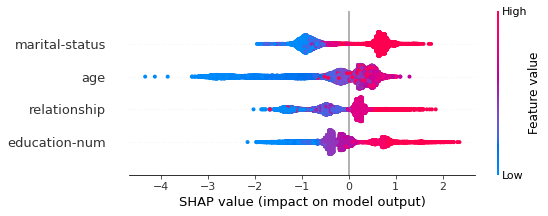

root - INFO - Getting value for save_shap_summary_plot
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


                 0         1
0              age  0.730312
1        workclass  0.091824
2           fnlwgt  0.141223
3        education   0.03331
4    education-num  0.493452
5   marital-status  0.776952
6       occupation  0.351193
7     relationship  0.523422
8             race  0.045024
9              sex  0.145845
10    capital-gain  0.474263
11    capital-loss  0.161146
12  hours-per-week  0.364119
13  native-country  0.034191
       column_name shap_importance
0              age        0.730312
1        workclass        0.091824
2           fnlwgt        0.141223
3        education         0.03331
4    education-num        0.493452
5   marital-status        0.776952
6       occupation        0.351193
7     relationship        0.523422
8             race        0.045024
9              sex        0.145845
10    capital-gain        0.474263
11    capital-loss        0.161146
12  hours-per-week        0.364119
13  native-country        0.034191
       column_name shap_importance
5   m

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.5565651976374375
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8158
           1       0.68      0.47      0.56      2588

    accuracy                           0.82     10746
   macro avg       0.76      0.70      0.72     10746
weighted avg       0.81      0.82      0.81     10746

Confusion matrix : 
[[7569  589]
 [1363 1225]]
